# Stochastic Resonance in a Bistable System: FFT Analysis

This notebook investigates stochastic resonance in a bistable system driven by weak periodic forcing and additive noise. We use Fast Fourier Transform (FFT) to identify resonance conditions under varying noise amplitudes.


## Objectives

- Simulate a bistable system under noisy conditions.
- Use FFT to detect resonance and frequency response.
- Explore how noise influences signal amplification through resonance.


## Theory: Stochastic Resonance & FFT

Stochastic resonance is a phenomenon in which a nonlinear system's response to a weak input signal is enhanced by the presence of noise. We model this using a double-well potential system subjected to sinusoidal forcing and random noise.

The Fast Fourier Transform (FFT) is applied to the output to identify the power spectral density and detect signal amplification near the driving frequency.


### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq, fftshift


rng = np.random.default_rng()

## Simulation Setup

We define the time grid, forcing parameters, and range of noise intensities. The differential equation is numerically integrated using the Euler-Maruyama method.


### Code: Bistable System with Noise

We simulate the following Langevin equation:

$$
dx = -\frac{dU(x)}{dx} dt + A \cos(\omega t) dt + \sqrt{2D} dW
$$

Where:


- $ U(x) = -\frac{1}{2}x^2 + \frac{1}{4}x^4$ is the bistable potential
- $D$ is the noise strength
- $A \cos(\omega t)$ is the weak periodic forcing
- $dW$ is the Wiener process increment

In [2]:
def euler_maruyama(A0, omega, D, x0, t, h):
    
    '''
    Simple numerical solution to SDE of bistable system with periodic time-dependent forcing.
    
    Parameters
    -----------
    A0: forcing amplitude

    omega: forcing frequency
    
    D: diffusion coefficient

    -----------
    '''
                                                                                             # Here dt = h
    x = np.zeros_like(t, dtype="float")                                                      # Create array of zeroes of length N

    #Set initial value of x
    x[0] = x0        

    #Calculate delta x for the N steps
    for r in range(len(x)-1):
        dW = np.sqrt(h) * rng.normal(0, 1)   

        x[r + 1] = x[r] + (x[r] - x[r]**3 + A0*np.cos(omega*t[r]))* h + np.sqrt(2*D) * dW    # Replace x with x+ delta x
                   
    return x


We start by simulating for a time $T = 90$  and  $h = 0.01$ ,  assuming $t_0 = 0$

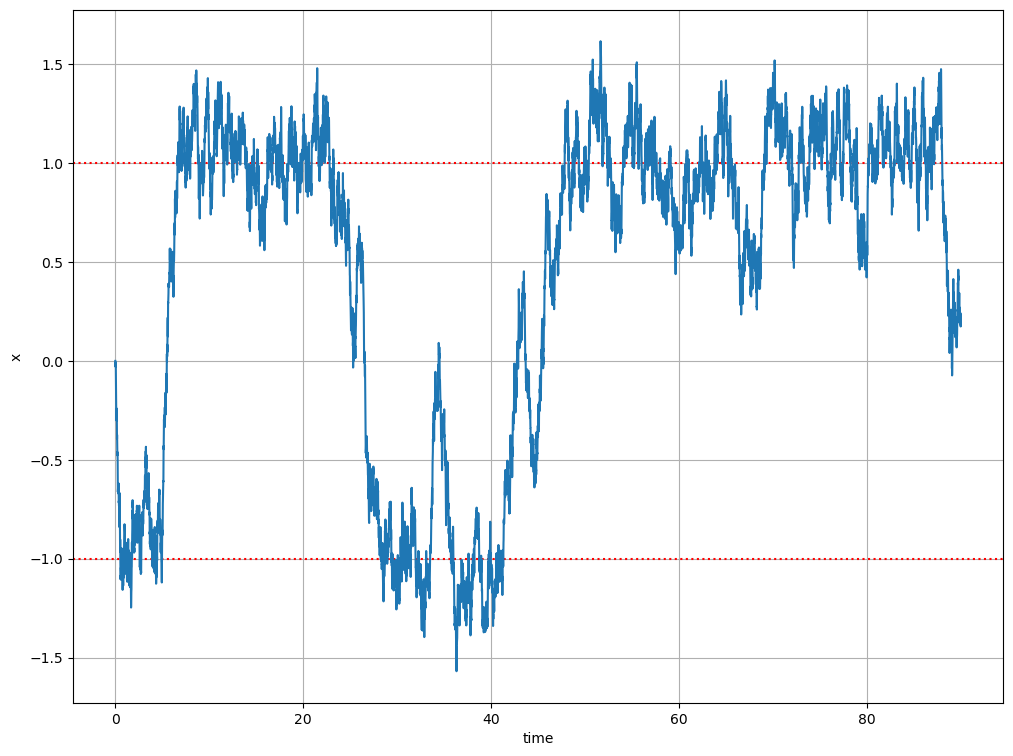

In [3]:
T = 90
h = 0.01
N = int(T/h)
t = np.linspace(0, T, N)

x = euler_maruyama(A0 = 0.2, omega=0.1, D =0.1, x0 = 0, t = t, h = h)
plt.figure(figsize = (12,9))
plt.grid(visible= True)
plt.axhline(1, color = "red" ,ls = ":",)
plt.axhline(-1, color = "red" ,ls = ":",)
plt.plot(t, x)
plt.xlabel('time')
plt.ylabel('x');

## FFT Analysis of Output Signal

We compute the FFT of the simulated time series to determine whether the weak periodic forcing is amplified near its driving frequency. We repeat this across different noise intensities to identify optimal stochastic resonance. We do this by generating 10 sample paths with $T = 4000$. After taking an average of the energy spectral densities we plot by the angular frequency $\omega$

In [4]:
T = 4000
h = 0.01
N = int(T/h)
t = np.linspace(0, T, N)
sample_paths = 10

paths = np.empty(shape = (sample_paths, N))
for r in range(sample_paths):
    paths[r] = euler_maruyama(A0 = 0.2, omega=0.1, D =0.1, x0 = 0, t = t, h = h)

Now we perform the FFT for each of these paths to find dominant frequencies and store them into a new variabole

In [5]:
FFT_paths = np.empty_like(paths, dtype = "complex")
path_number = 0
for path in paths:
    FFT_paths[path_number] = fft(path, norm ='forward')
    path_number +=1

We compute the energy spectral density for each one of the paths 

In [6]:

S_n_paths = np.real(FFT_paths * np.conjugate(FFT_paths))

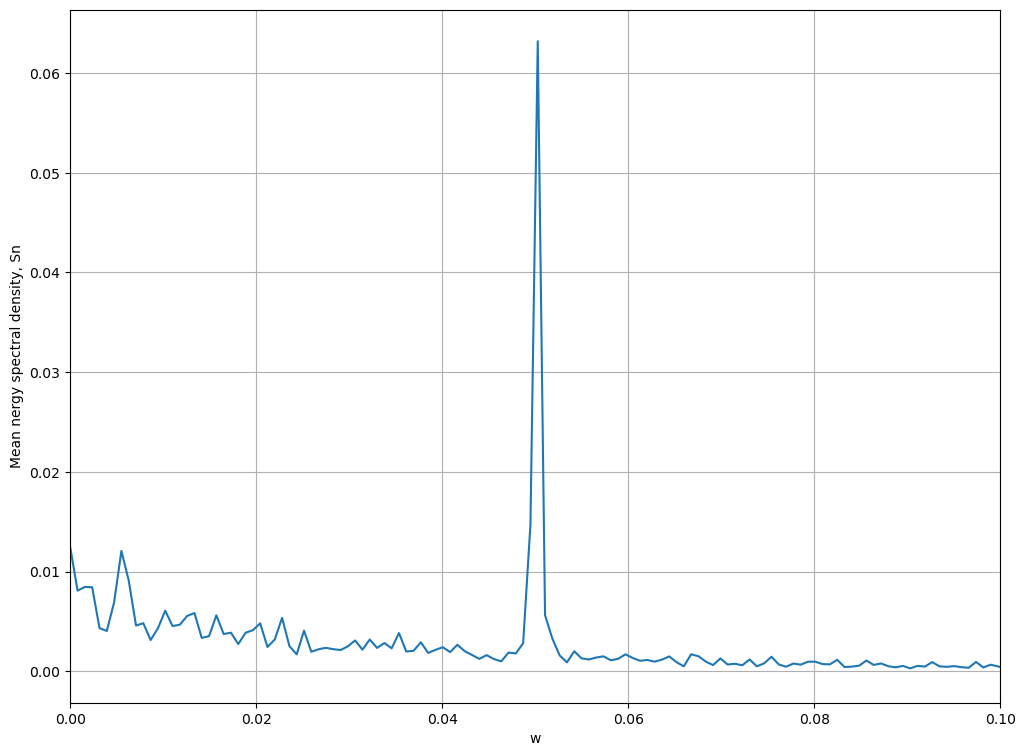

In [7]:

#Getting the frequencies
n = np.arange(-N/2,N/2,1)   # Generate the n

# As we have f = n / tN, and w = 2pif = 2pi n/Tn, we have
w = np.pi * n / T

# We make an average of the 10 Energy spectral densities
Sn_mean = np.mean(S_n_paths, axis = 0)
plt.figure(figsize= (12,9))
plt.grid(visible = True)
plt.plot(w, fftshift(Sn_mean))
plt.xlabel('w')
plt.ylabel('Mean nergy spectral density, Sn')
plt.xlim(0,0.1);

We can see how the energy spectral density peaks for a value of about $\omega = 0.05$

### Compute Spectral Peak Amplitude

The function `S_peak(D, omega)` simulates multiple paths of the bistable system at a given noise intensity `D` and driving frequency `omega`. For each path, it performs an FFT and computes the energy spectral density. The function returns the **maximum peak** of the averaged power spectrum, which is used as a proxy for resonance strength. The output of the function is used to compute the spectral amplification using the equation:
$$
\eta = \frac{S_peak}{A_0}
$$



This spectral amplification refers to the enhancement of specific frequency components in a system's output signal. In this context, it describes how the presence of noise (of a certain intensity) amplifies the system's response at the **driving frequency** of a weak sinusoidal signal.

To quantify this, we:
- Simulate multiple realizations of the system.
- Perform a **Fast Fourier Transform (FFT)** on each trajectory.
- Compute the **energy spectral density** for each path.
- Average across all paths to reduce noise variability.
- Extract the **peak value** of the averaged spectrum at positive frequencies.

This peak represents the **resonant response** of the system. By plotting it across different noise levels \( D \), we observe a **resonance curve**, where a specific noise intensity maximizes the system's sensitivity to the input signal — a hallmark of stochastic resonance.


Compared to our earlier simulation, this function uses a value of h that is $h = 0.1$  for the purpose of saving time, as several paths are simulated for different values of D

In [8]:
def S_peak(D, omega):
    """
    Computes the peak spectral amplification of a bistable system subjected to noise and sinusoidal forcing.

    Parameters:
    -----------
    D : float
        Noise intensity in the system.
    omega : float
        Angular frequency of the external driving signal.

    Returns:
    --------
    float
        The maximum value of the averaged energy spectral density at positive frequencies,
        representing the system's spectral response at given noise intensity.
    
    Method:
    -------
    - Simulates multiple stochastic trajectories using the Euler-Maruyama scheme.
    - Applies FFT to each trajectory to obtain the power spectrum.
    - Averages the power spectra over all trajectories.
    - Returns the peak of the resulting mean power spectrum (positive frequencies only).
    """
    
    T = 4000
    h = 0.1
    N = int(T/h)
    t = np.linspace(0, T, N)
    sample_paths = 10

    paths = np.empty((sample_paths, N))
    for r in range(sample_paths):
        paths[r] = euler_maruyama(A0=0.2, omega=omega, D=D, x0=0, t=t, h=h)

    FFT_paths = np.empty_like(paths, dtype="complex")
    for i, path in enumerate(paths):
        FFT_paths[i] = fft(path, norm='forward')

    n = np.arange(-N/2, N/2, 1)
    w = np.pi * n / T

    S_n_paths = np.real(FFT_paths * np.conjugate(FFT_paths))
    Sn_mean = np.mean(S_n_paths, axis=0)

    half_w = int(len(w) / 2)
    positive_Sn = fftshift(Sn_mean)[half_w:]

    return np.max(positive_Sn)


We generate 40 paths with value of D ranging from 0.01 to 0.4

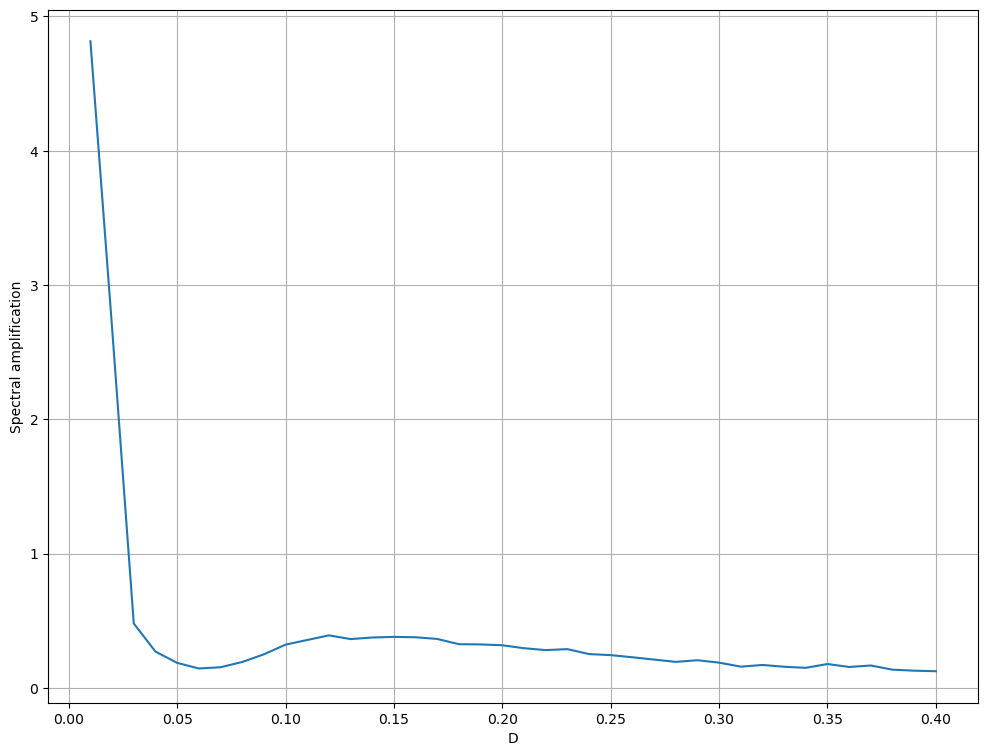

In [14]:
D_values = np.linspace(0.01,0.4,num = 40)
Speak = np.empty_like(D_values)

index = 0    #Index for the peaks
for D in D_values:
    Speak[index] = S_peak(D, omega = 0.1)
    index += 1


#Computing spectral amplification eta

eta = Speak/0.2
plt.figure(figsize = (12,9))
plt.plot(D_values, eta)
plt.grid(visible = True)
plt.xlabel('D')
plt.ylabel('Spectral amplification');

## Results: Peak vs. Noise Strength

By calling `S_peak()` across a range of noise values, we generate a resonance curve that shows the optimal noise level where signal amplification is maximized.


In [15]:
Speak01 = np.empty_like(D_values)    # Omega = 0.1

index = 0    #Index for the peaks
for D in D_values:
    Speak01[index] = S_peak(D, omega = 0.1)
    index += 1

Speak002 = np.empty_like(D_values)    # Omega = 0.02

index = 0    #Index for the peaks
for D in D_values:
    Speak002[index] = S_peak(D, omega = 0.02)
    index += 1

Speak005 = np.empty_like(D_values)    # Omega = 0.05

index = 0    #Index for the peaks
for D in D_values:
    Speak005[index] = S_peak(D, omega = 0.05)
    index += 1
eta01 = Speak01/0.2
eta002 = Speak002/0.2
eta005 = Speak005/0.2


## Plotting the results 

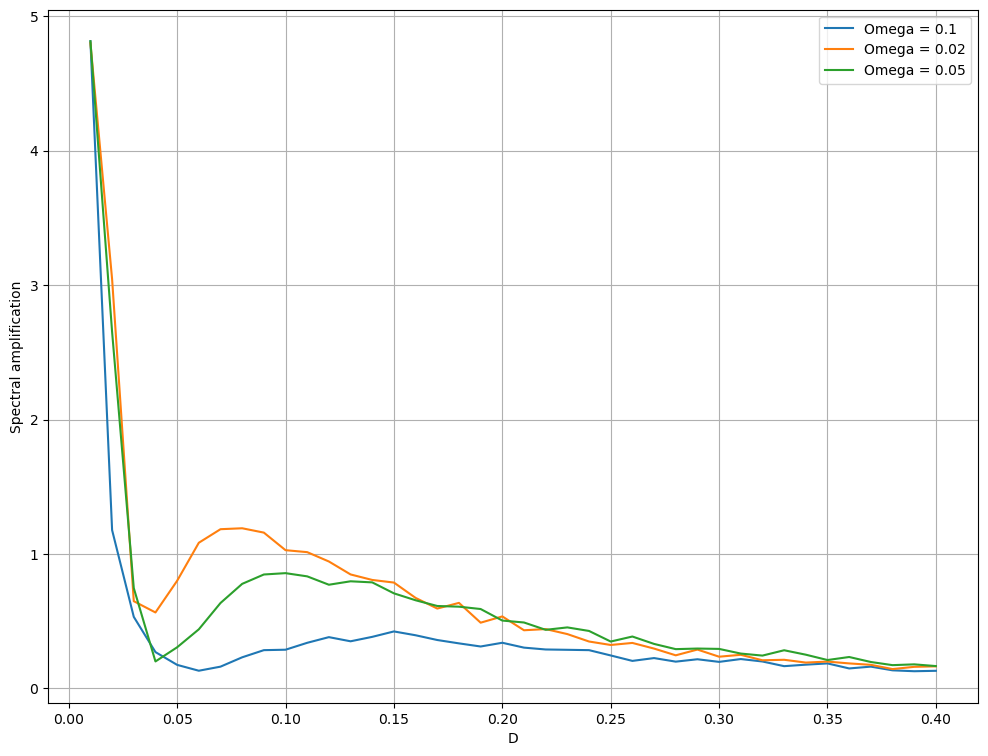

In [17]:
plt.figure(figsize = (12,9))
plt.plot(D_values, eta01, label = "Omega = 0.1")
plt.plot(D_values, eta002, label = "Omega = 0.02")
plt.plot(D_values, eta005, label = "Omega = 0.05")
plt.grid(visible = True)
plt.xlabel('D')
plt.ylabel('Spectral amplification')
plt.legend();

## Conclusion

- The FFT confirms enhanced signal amplification at specific noise intensities.
- The `S_peak` function provides a quantitative way to measure resonance.
- The resonance phenomenon demonstrates how noise can aid detection of weak signals in nonlinear systems.


## References

- Gammaitoni et al., "Stochastic Resonance," Rev. Mod. Phys., 1998.
- Open University MST374 Coursework.
